# Programming Assignment 5: Diffusion Models (optional)

# Overview

<font size='4'>In this assignment, you will practice implementing [DDPM](https://arxiv.org/pdf/2006.11239) (denoising diffusion probabilistic models) for grayscale image generation. After finishing this programming assignment, you will get good understandings about foundations for very state-of-the-art image generation models that you likely see in tech news articles nowadays, like Stable Diffusion, Sora.</font>

## Submission format

<font size='4'>`<your_nu_username>_pa5.ipynb` with your implementations and output.</font>

## Note

<font size='4'>  

- **Read the instructions and comments very carefully to avoid waste of your valuable time and deduction of points.**

- You do not install any additional packages inside the Colab environment. Do not forget to choose to use GPU in the `Runtime\Change runtime type` tab.    

- **You are not allowed to look for answers online, except for the links provided in this assignment.**

- **Violation of this policy will lead to failure of your course and even more severe consequences.**

- **Only work on it when you have bandwidth since you may loose more for the final project than what you can get here.**
</font>


## Setup

In [1]:
import os
from typing import Dict, Tuple
from tqdm import tqdm
import numpy as np
import random
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image, make_grid

%matplotlib inline
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('We are using the device {}.'.format(device))

We are using the device cuda:0.


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:00<00:00, 76410910.44it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 2820454.35it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found


100%|██████████| 1648877/1648877 [00:00<00:00, 21902783.17it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 8742785.12it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

There are 12665 images in total.


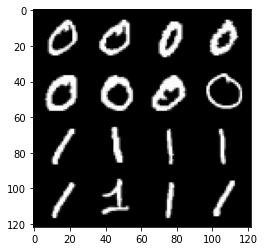

In [2]:
# We will be using a subset of the MNIST dataset
# (https://en.wikipedia.org/wiki/MNIST_database#:~:text=The%20MNIST%20database%20(Modified%20National,training%20various%20image%20processing%20systems.).
# To save some computation burden, we will only be using images with labels of 0 and 1.

class SubsetMNIST(MNIST):
    @property
    def raw_folder(self) -> str:
        return os.path.join(self.root, 'MNIST', "raw")


    def __init__(self,
        root: Union[str, Path],
        train: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
    ) -> None:
        super().__init__(
            root, transform=transform,
            target_transform=target_transform,
            download=download
        )

        sub_data = []
        sub_targets = []
        n_total = len(self.data)
        for i in range(n_total):
            if self.targets[i] in [0, 1]:
                sub_data.append(self.data[i])
                sub_targets.append(self.targets[i])

        self.data = sub_data
        self.targets = sub_targets

dataset = SubsetMNIST(
    "./data",
    train=True,
    download=True
)
print(f'There are {len(dataset)} images in total.')

num_show = 16
show_im_zero = np.zeros((num_show // 2, 1, 28, 28))
show_im_one = np.zeros((num_show // 2, 1, 28, 28))
num_zero = 0
num_one = 0
# randomly sample images
for data, label in dataset:
    if label  == 0 and num_zero < num_show // 2:
        show_im_zero[num_zero, :] = data
        num_zero += 1
    if label == 1 and num_one < num_show // 2:
        show_im_one[num_one, :] = data
        num_one += 1

# let's take a look at what the training data looks like
show_im = np.concatenate((show_im_zero, show_im_one), axis=0)
show_im = make_grid(torch.from_numpy(show_im), nrow=4, normalize=True)
plt.imshow(show_im.numpy().transpose(1, 2, 0))
plt.show()



## <font color='red'>Task 1: Implement a UNet (5 points). </font>

In [3]:
class UNet(nn.Module):
    """
    A UNet model that takes an image as input and output another image with the
    **same** spatial dimension.
    """
    def __init__(self, in_planes, inter_planes=128):
        super(UNet, self).__init__()
        """
        Inputs:
          - in_planes: number of channels in the input
          - inter_planes: a base number for number of channels in the intermediate
            output of the UNet
        """

        # encoder with 3 blocks
        self.block1 = None
        self.block2 = None
        self.block3 = None

        # decoder with another 3 blocks
        self.block4 = None
        self.block5 = None
        self.block6 = None

        # output layer
        self.out_layer = None

        ###########################################################################
        # TODO: Implement all blocks and the output layer. For each block in the  #
        # encoder, the downsampling factor should be 2. So for an MNIST images of #
        # 28x28, the output dimensions of the three blocks should be 14x14, 7x7,  #
        # and 4x4, respectively. For each block in the decoder, we do upsampling  #
        # with a factor of 2. Check torch.nn.Sample on how to do it. You can also #
        # do upsampling using torch.nn.functional.interpolate in the forward()    #
        # function. Recall a critical design in UNet is to fuse the features      #
        # with the same spatial dimensions across the encoder and decoder. Here   #
        # we can concatenate them along the channel dimension. The channel        #
        # dimensions across the six blocks should be inter_planes, 2*inter_planes,#
        # 4*inter_planes, 4*inter_planes, 2*inter_planes, and inter_planes,       #
        # respectively.                                                           #
        #                                                                         #
        # Also implement the output layer. The total number of parameters should  #
        # be smaller than 15M.                                                    #
        #                                                                         #
        # You are encouraged to experiment with different ways of composing the   #
        # blocks.                                                                 #
        ###########################################################################

        self.block1 = nn.Sequential(
            nn.Conv2d(in_planes, inter_planes, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(inter_planes, inter_planes, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(inter_planes, inter_planes, kernel_size=3, stride=2, padding=1)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(inter_planes, 2*inter_planes, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(2*inter_planes, 2*inter_planes, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(2*inter_planes, 2*inter_planes, kernel_size=3, stride=2, padding=1)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(2*inter_planes, 4*inter_planes, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(4*inter_planes, 4*inter_planes, kernel_size=3, stride=2, padding=1)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(8*inter_planes, 4*inter_planes, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(4*inter_planes, 4*inter_planes, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.block5 = nn.Sequential(
            nn.Conv2d(6*inter_planes, 2*inter_planes, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(2*inter_planes)
        )

        self.block6 = nn.Sequential(
            nn.Conv2d(3*inter_planes, inter_planes, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(inter_planes)
        )

        self.out_layer = nn.Conv2d(inter_planes, in_planes, kernel_size=1)

        # raise NotImplementedError
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, x):
        """
        Forward process of the UNet.
        Input:
          - x: shape of BxCxHxW, input images
          - y: shape of BxCxHxW, output images
        """

        output = None
        ###########################################################################
        # TODO: Implement the forward process of the UNet.                        #
        ###########################################################################

        enc1 = self.block1[:-1](x)
        x = self.block1[-1](enc1)

        enc2 = self.block2[:-1](x)
        x = self.block2[-1](enc2)

        enc3 = self.block3[:-1](x)
        x = self.block3[-1](enc3)

        x = F.interpolate(x, size=enc3.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, enc3], dim=1)
        x = self.block4(x)

        x = F.interpolate(x, size=enc2.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, enc2], dim=1)
        x = self.block5(x)

        x = F.interpolate(x, size=enc1.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, enc1], dim=1)
        x = self.block6(x)

        output = self.out_layer(x)

        # raise NotImplementedError
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return output

In [4]:
# sanity check of tensor shapes
x = torch.randn((3, 1, 28, 28))
model = UNet(1)
y = model(x)
for dim_y, dim_x in zip(y.shape, x.shape):
    assert dim_y == dim_x
print('output shape: ', y.shape)
num_params = sum(p.numel() / 1000000 for p in model.parameters())
assert num_params < 15
print('Num parameters: {:.2f}M'.format(num_params))

output shape:  torch.Size([3, 1, 28, 28])
Num parameters: 14.60M


## <font color='red'> Task 2: Implement DDPM for both the $x_0$ and $\epsilon$ variants (8 points).</font>

<font size='4' color='red'>
Some important notes before you start implementing the DDPM model. Read them carefully.
</font>

<font size='4'>

- We will mostly follow the tutorial https://arxiv.org/pdf/2403.18103.

- There is a typo in the training algorithm on Page 36. It should be
$$
\mathbf{x}_t^{(m)} = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\mathbf{\epsilon}^{(m)}.
$$

- For both the inference algorithms on Page 37 and Page 39, we will simply define $\sigma_q(t) = 1 - \alpha_t$.

- We will mostly use the notations in the tutorial. In the literature and the original paper of DDPM (https://arxiv.org/pdf/2006.11239), you will see $\beta_t$, which is simply defined $\beta_t = 1 - \alpha_t$.
</font>

In [46]:
class DDPM(nn.Module):
    """
    Class of denoising diffusion probabilistic model (DDPM).
    The original paper is at https://arxiv.org/pdf/2006.11239.
    But you are encouraged to read the tutorial https://arxiv.org/pdf/2403.18103
    for detailed mathematical derivations.
    In this implementation, we will use a linear scheduler for the noise between
    alpha_1 and alpha_T.
    """

    def __init__(
            self,
            unet: nn.Module,
            alpha_1: float,
            alpha_T: float,
            T: int,
            criterion: nn.Module,
            denoising_objective: str = 'x_zero',
    ) -> None:
        """
        Inputs:
          - unet: A UNet model.
          - alpha_1: a scalar denoting the smallest alpha value
          - alpha_T: a scalar denoting the largest alpha value
          - T: number of denoising diffusion steps
          - criterion: a torch.nn.Module denoting the loss function
          - denoising_objective: a string denoting the denoising objective: x_zero or epsilon
        """
        super(DDPM, self).__init__()

        self.unet = unet
        self.alpha_1 = alpha_1
        self.alpha_T = alpha_T
        self.T = T
        self.criterion = criterion
        assert denoising_objective in ['x_zero', 'epsilon']
        self.denoising_objective = denoising_objective

        # hard-coded image spatial dimension for MNIST
        self.im_size = (28, 28)

        # a linear noise scheduler
        alpha_t_list = (alpha_1 - alpha_T) * torch.arange(0, T + 1, dtype=torch.float32) / T + alpha_T
        # by registering it, you can later use it as self.alpha_t_list
        self.register_buffer('alpha_t_list', alpha_t_list)

    def get_alpha(self, t: int) -> Tuple[float, float]:
        # given a particular denoising step t, return alpha_t and \bar{alpha}_t
        # we use a linear scheduler here
        alpha_t = self.alpha_t_list[t, None, None, None]
        alpha_bar_t = torch.cumprod(self.alpha_t_list, dim=0)[t, None, None, None]
        return alpha_t.to(device), alpha_bar_t.to(device)

    def forward_train(self, x: torch.Tensor) -> torch.Tensor:
        """
        For forward diffusion process of a DDPM model. Refer to the training algorithms
        on Page 36 and Page 38, respectively, for the x_zero and epsilon models.

        Input:
          - x: x_0, clearn image, shape of BxCxHxW

        Output:
          - loss: a scalar tensor of the loss between the UNet's output and the ground
            truth defined in the DDPM variant (x_zero or epsilon)
        """
        # randomly take a time step t between 1 to T
        t = torch.randint(1, self.T + 1, (x.shape[0],)).to(x.device)

        # get alpha_t and \bar{alpha}_t
        alpha_t, alpha_bar_t = self.get_alpha(t)

        # sample noise epsilon ~ N(0, 1)
        epsilon_t = torch.randn_like(x)

        loss = None
        ###########################################################################
        # TODO: Compute x_t according to the definition and feed it to the UNet   #
        # to get the output, which will be compared with the ground truth         #
        # according to the denoising objective.                                   #
        ###########################################################################

        x_t = torch.sqrt(alpha_bar_t) * x + torch.sqrt(1 - alpha_bar_t) * epsilon_t

        output = self.unet(x_t)

        if self.denoising_objective == 'x_zero':
            loss = self.criterion(output, x)
        else:
            loss = self.criterion(output, epsilon_t)

        # raise NotImplementedError
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return loss

    def forward_test(self, num_samples: int=16, im_size: Tuple[int, int, int] = (1, 28, 28), store_interval=-1) -> torch.Tensor:
        """
        Inference behavior (denoising process) of the model.

        Inputs:
          - num_samples: number of images to generate
          - im_size: shape (C, H, W) of the generated images
          - store_interval: frequency of storing the generated images along the denoising process

        Output:
          - x_0: generated clean, noise-free images
          - inter_x: generated intermediate images along the denoising process
        """

        # x_T ~ N(0, 1), a pure Gaussian noise image
        x_t = torch.randn(num_samples, *im_size).to(device)

        # clean, noise-free image
        x_0 = None
        # list to store those intermediate generated images
        inter_x_list = []

        # gradually denoise the initial image x_t according to the denoising objective
        for t in range(self.T, 0, -1):
            # alpha
            alpha_t, alpha_bar_t = self.get_alpha(t)
            _, alpha_bar_t_1 = self.get_alpha(t - 1)

            ###########################################################################
            # TODO: Implement the denoising process (inference algorithms) of DDPM    #
            # according to the denoising objective.                                   #
            ###########################################################################

            if self.denoising_objective == 'epsilon':
                predicted_noise = self.unet(x_t)

                mean = (x_t - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * predicted_noise) / torch.sqrt(alpha_t)

                variance = 1 - alpha_t
                std_dev = torch.sqrt(variance)

                noise = torch.randn_like(x_t) if t > 1 else torch.zeros_like(x_t)

                x_t = mean + std_dev * noise

            else:
                predicted_x0 = self.unet(x_t)

                mean = (torch.sqrt(alpha_bar_t_1) * (1 - alpha_t) / (1 - alpha_bar_t)) * predicted_x0 + \
                      (torch.sqrt(alpha_t) * (1 - alpha_bar_t_1) / (1 - alpha_bar_t)) * x_t

                variance = 1 - alpha_t
                std_dev = torch.sqrt(variance)

                noise = torch.randn_like(x_t) if t > 1 else torch.zeros_like(x_t)

                x_t = mean + std_dev * noise

            # raise NotImplementedError
            ###########################################################################
            #                             END OF YOUR CODE                            #
            ###########################################################################

            if t == 1 or (store_interval > 0 and t % store_interval == 0):
                inter_x_list.append(x_t)

        x_0 = x_t
        if store_interval > 0:
            assert len(inter_x_list) > 0
            inter_x = torch.stack(inter_x_list, dim=0)
        else:
            inter_x = None

        return x_0, inter_x

    def forward(self, x: torch.Tensor = None, num_samples: int = 16, im_size: Tuple[int, int, int] = (1, 28, 28), store_interval=-1) -> torch.Tensor:
        if self.training:
            # raining-time behavior
            assert x is not None
            return self.forward_train(x)

        # testing-time behavior
        return self.forward_test(num_samples, im_size, store_interval)

## <font color='red'> Task 3: Implementation of training and evaluation of a DDPM model (1 point).

In [47]:
def train_eval_ddpm(dataloader, n_epoch: int, alpha_1, alpha_T, T, denoising_objective='x_zero') -> None:
    """
    Training and evaluation of a DDPM model.

    Inputs:
      - dataloader: SubMNIST data loader
      - nepoch: number of epochs
      - alpha_1: smallest alpha value
      - alpha_T: largest alpha value
      - T: number of denoising steps
      - denoising_objective: x_zero or episolon

    output:
      - ddpm: the trained DDPM model
    """
    assert denoising_objective in ['x_zero', 'epsilon']

    ddpm = None
    ###########################################################################
    # TODO: Define a DDPM model.                                              #
    ###########################################################################

    unet = UNet(in_planes=1)
    criterion = nn.MSELoss()
    ddpm = DDPM(
        unet=unet,
        alpha_1=alpha_1,
        alpha_T=alpha_T,
        T=T,
        criterion=criterion,
        denoising_objective=denoising_objective
    )

    # raise NotImplementedError
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    ddpm.to(device)

    # hard-coded learning rate
    optim = torch.optim.Adam(ddpm.parameters(), lr=2e-4)

    for i in range(n_epoch):
        # set the ddpm to train
        ddpm.train()
        progress_bar = tqdm(dataloader)
        # an exponential moving average with discount factor 0.1
        total_loss = None
        for x, _ in progress_bar:
            optim.zero_grad()
            x = x.to(device)
            loss = ddpm(x)
            loss.backward()
            if total_loss is None:
                total_loss = loss.item()
            else:
                # 10% from immediate loss and 90% from previous average
                total_loss = 0.9 * total_loss + 0.1 * loss.item()
            progress_bar.set_description(f"epoch: {(i+1)}, loss: {total_loss:.4f}")
            optim.step()

        # set the ddpm to eval
        ddpm.eval()
        with torch.no_grad():
            xh, _ = ddpm(num_samples=16, im_size=(1, 28, 28))
            grid = make_grid(xh, nrow=4, normalize=True)
            plt.imshow(grid.cpu().numpy().transpose(1, 2, 0))
            plt.show()

    return ddpm

In [48]:
def generate_images(ddpm, im_size=(1, 28, 28), store_interval=-1) -> None:
    # set the ddpm to eval
    ddpm.eval()
    with torch.no_grad():
        xh, inter_x = ddpm(num_samples=4, im_size=im_size, store_interval=store_interval)
        grid = make_grid(xh, nrow=4, normalize=True)
        N, B, C, H, W = inter_x.shape
        inter_x = inter_x.view(N * B, C, H, W)
        inter_grid = make_grid(inter_x, nrow=B, normalize=True)

    return grid, inter_grid

In [49]:
# read the MNIST dataset into a dataloader
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0))])
dataset = SubsetMNIST(
    "./data",
    train=True,
    download=True,
    transform=tf,
)
mnist_dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=1)

## <font color='red'> Task 4: Tuning the hyper parameters for the x_zero DDPM variant (2 points).

epoch: 1, loss: 0.1571: 100%|██████████| 99/99 [00:07<00:00, 13.00it/s]


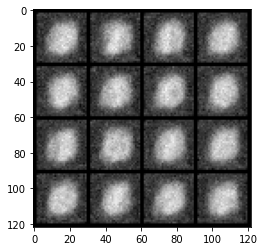

epoch: 2, loss: 0.0942: 100%|██████████| 99/99 [00:07<00:00, 13.15it/s]


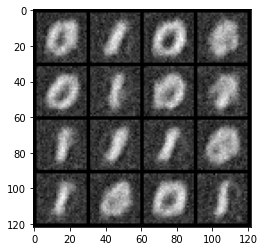

epoch: 3, loss: 0.0612: 100%|██████████| 99/99 [00:07<00:00, 13.04it/s]


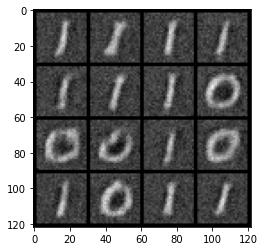

epoch: 4, loss: 0.0484: 100%|██████████| 99/99 [00:07<00:00, 13.01it/s]


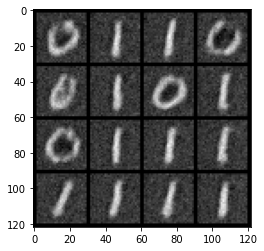

epoch: 5, loss: 0.0459: 100%|██████████| 99/99 [00:07<00:00, 13.04it/s]


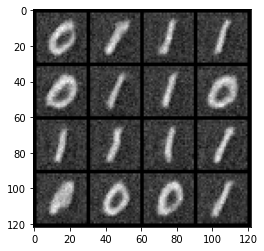

In [50]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

num_epochs = 5
###########################################################################
# TODO: Tune the hyper parameters of alpha_1 and alpha_T until you can    #
# satisfied generation results (it is left vague for you to figure out).  #
###########################################################################
alpha_1 = 0.9999
alpha_T = 0.985
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################
T = 500
denoising_objective = 'x_zero'
ddpm_x_zero = train_eval_ddpm(dataloader=mnist_dataloader, n_epoch=num_epochs, alpha_1=alpha_1, alpha_T=alpha_T, T=T, denoising_objective=denoising_objective)

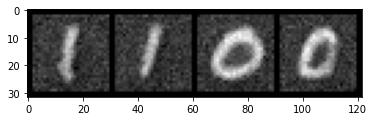

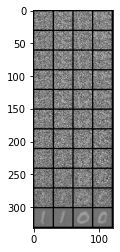

In [51]:
# let's see how the denoising process works
im_grid, inter_im_grid = generate_images(ddpm_x_zero, (1, 28, 28), T // 10)

# final generated images
plt.imshow(im_grid.cpu().numpy().transpose(1, 2, 0))
plt.show()

# visualizations of the intermediate images
# note there are negative values in the initial noisy images, with normalization,
# the final clean images will look gray in the background (not very black)
plt.imshow(inter_im_grid.cpu().numpy().transpose(1, 2, 0))
plt.show()

## <font color='red'> Task 5: Briefly describe your experience and observations of tuning hyper parameters for the x_zero DDPM variant (1 point).

[Your answer]:

- When alpha_1 is close to 1, the model started from almost noise-free to more stable early noising.

- Higher alpha_T values gives sharper and cleaner images but sometimes reduced diversity.

- Lower alpha_T allowed more variations but sometimes leads to noisier and less sharp samples.

## <font color='red'> Task 6: Tuning the hyper parameters for the epsilon DDPM variant (2 points).

epoch: 1, loss: 0.0132: 100%|██████████| 99/99 [00:07<00:00, 12.87it/s]


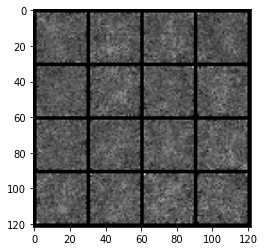

epoch: 2, loss: 0.0084: 100%|██████████| 99/99 [00:07<00:00, 13.03it/s]


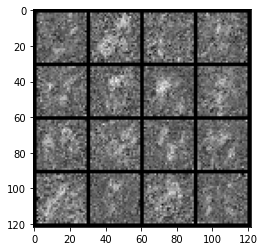

epoch: 3, loss: 0.0075: 100%|██████████| 99/99 [00:07<00:00, 12.95it/s]


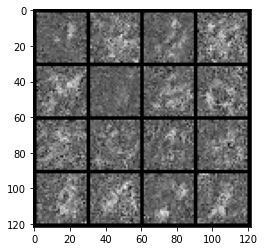

epoch: 4, loss: 0.0067: 100%|██████████| 99/99 [00:07<00:00, 13.22it/s]


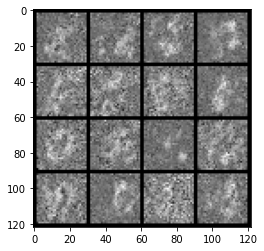

epoch: 5, loss: 0.0063: 100%|██████████| 99/99 [00:07<00:00, 13.16it/s]


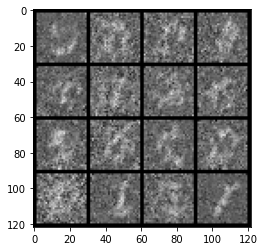

epoch: 6, loss: 0.0066: 100%|██████████| 99/99 [00:07<00:00, 13.13it/s]


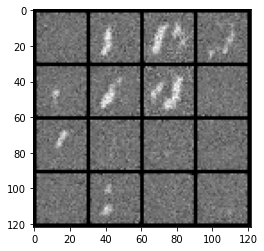

epoch: 7, loss: 0.0058: 100%|██████████| 99/99 [00:07<00:00, 12.93it/s]


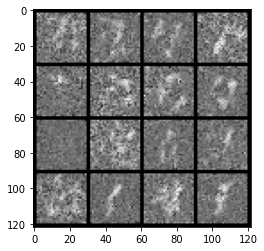

epoch: 8, loss: 0.0050: 100%|██████████| 99/99 [00:07<00:00, 13.20it/s]


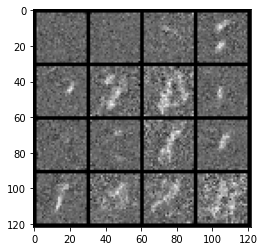

epoch: 9, loss: 0.0055: 100%|██████████| 99/99 [00:07<00:00, 13.10it/s]


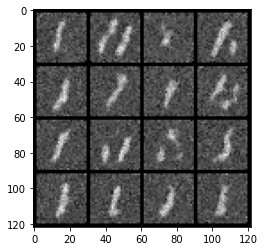

epoch: 10, loss: 0.0053: 100%|██████████| 99/99 [00:07<00:00, 13.21it/s]


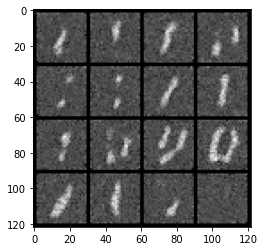

In [56]:
num_epochs = 10
###########################################################################
# TODO: Tune the hyper parameters of alpha_1 and alpha_T until you can    #
# satisfied generation results (it is left vague for you to figure out).  #
###########################################################################
alpha_1 = 0.9999
alpha_T = 0.98
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################
T = 1000
denoising_objective = 'epsilon'
ddpm_epsilon = train_eval_ddpm(dataloader=mnist_dataloader, n_epoch=num_epochs, alpha_1=alpha_1, alpha_T=alpha_T, T=T, denoising_objective=denoising_objective)

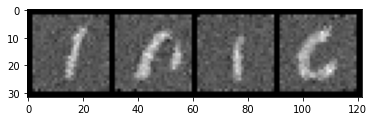

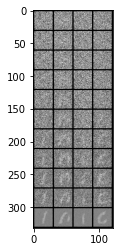

In [57]:
# let's see how the denoising process works
im_grid, inter_im_grid = generate_images(ddpm_epsilon, (1, 28, 28), T // 10)

# final generated images
plt.imshow(im_grid.cpu().numpy().transpose(1, 2, 0))
plt.show()

# visualizations of the intermediate images
# note there are negative values in the initial noisy images, with normalization,
# the final clean images will look gray in the background (not very black)
plt.imshow(inter_im_grid.cpu().numpy().transpose(1, 2, 0))
plt.show()

## <font color='red'> Task 7: Briefly describe your experience and observations of tuning hyper parameters for the epsilon DDPM variant (1 point).

[Your answer]:

- Using higher alpha_1 helped maintain stability during the early diffusion steps. Lower alpha_1 values added more noise early on, making the process unstable.
- Lower alpha_T increased noise toward the final steps, forcing the model to learn better denoising. Higher alpha_T values made the final steps less noisy, but sometimes made learning less effective if too high.
